# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook I demonstrate traffic sign classification with a convolutional neural network coupled with image pre-processing. Training/validation/test imagery comes from a provided collection of German traffic signs and samples obtained via Google Street View in/around Düsseldorf and Hamburg.

I emphasized neural network structure/hyperparameter evaluation over image pre-processing techniques.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Load training, validation, and test datasets via pickle.
training_file = 'input_data/train.p'
validation_file='input_data/valid.p'
testing_file = 'input_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Map to convenient globals
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Check dimension assumptions
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))


---

## Step 1: Dataset Summary & Exploration

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape_raw = X_train[0].shape
arr_shape_raw = X_train.shape

# How many unique classes/labels there are in the dataset?
set_classes = set(y_train)
n_classes = len(set_classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape_raw)
print("Array data shape =", arr_shape_raw)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Array data shape = (34799, 32, 32, 3)
Number of classes = 43


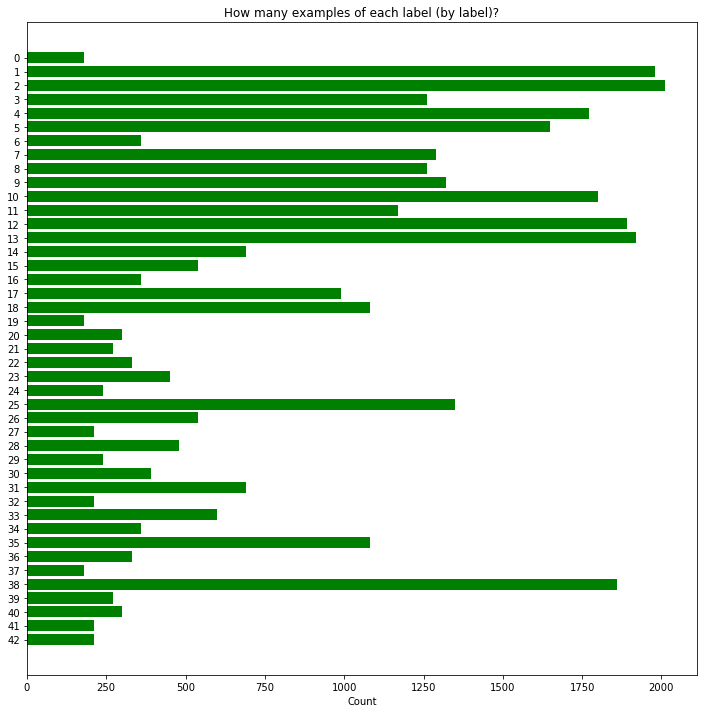

Examples of each label (raw):


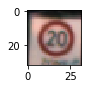

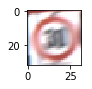

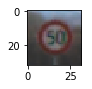

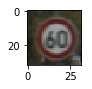

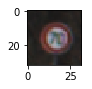

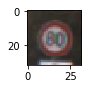

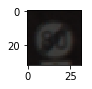

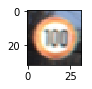

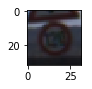

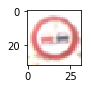

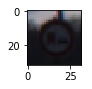

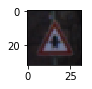

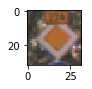

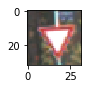

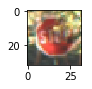

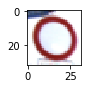

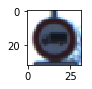

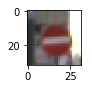

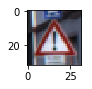

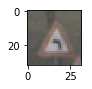

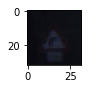

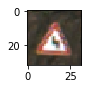

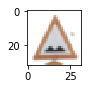

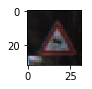

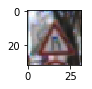

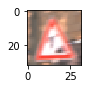

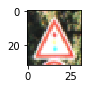

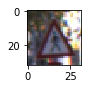

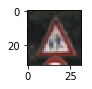

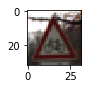

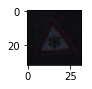

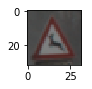

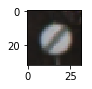

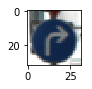

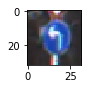

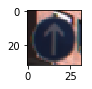

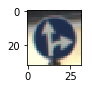

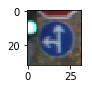

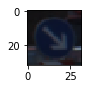

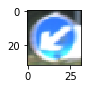

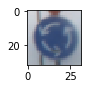

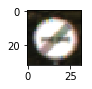

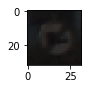

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Visualizations will be shown in the notebook.
%matplotlib inline

# (1) Map labels/images
dict_train_raw = defaultdict(list)
for key, value in zip(y_train,X_train):
    dict_train_raw[key].append(value)
  
# plt.rcdefaults()
plt.rcParams['figure.max_open_warning'] = 0

# (2) Count & plot distribution (in order)
train_labels = list(dict_train_raw.keys())
train_counts = list(len(value) for value in dict_train_raw.values())

fig,ax = plt.subplots(figsize=(12, 12))
ax.barh(train_labels, train_counts, align='center',
        color='green', ecolor='black')
ax.set_yticks(train_labels)
ax.set_yticklabels(train_labels)
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_title('How many examples of each label (by label)?')

plt.show()

# (3) Plot examples
print ("Examples of each label (raw):")
for key, value in dict_train_raw.items():
    index = random.randint(0, (len(value)-1))
    image = value[index].squeeze()

    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")


---

## Step 2: Image Pre-Processing

I provided a simple grayscale and/or normalization pre-processing step to (a) constrain training/validation permutations and (b) emphasize network structure and hyperparameters.

In [4]:
def pre_process_images(X_input,curr_grayscale,curr_normalize):
    """ Per-image pre-processing.
    """
    X_output = np.copy(X_input)
    
    # (1) Grayscale image
    if curr_grayscale:
        X_output = np.dot(X_output[...,:3], [0.299, 0.587, 0.114])
        X_output = np.expand_dims(X_output,axis=3)

    # (2) Noramlize pixels
    if curr_normalize:
        X_output = (X_output - 128.0)/128.0

    return X_output

In [5]:
def build_images(X_train,X_valid,X_test,curr_grayscale,curr_normalize):
    """ Pre-processing for training/validation/test sets.
    """
    # (1) Build images
    X_train_pre = pre_process_images(X_train,curr_grayscale,curr_normalize)    
    X_valid_pre = pre_process_images(X_valid,curr_grayscale,curr_normalize)
    X_test_pre = pre_process_images(X_test,curr_grayscale,curr_normalize)
    
    # (2) Build metrics
    image_shape_pre = X_train_pre[0].shape
    image_depth_pre = image_shape_pre[2]
    image_width = image_shape_pre[0]
    image_height = image_shape_pre[1]    
    
    return X_train_pre, X_valid_pre, X_test_pre, image_depth_pre, image_width, image_height

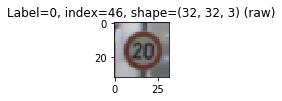

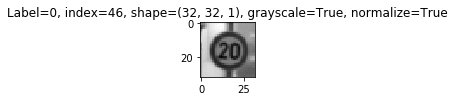

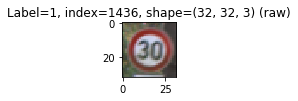

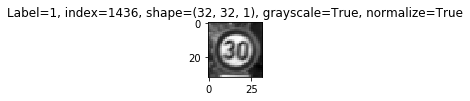

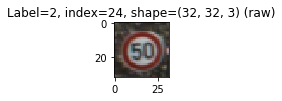

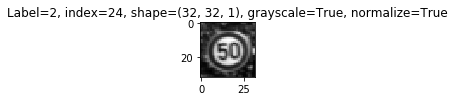

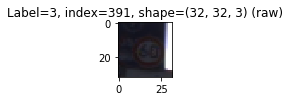

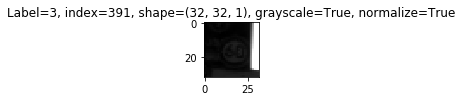

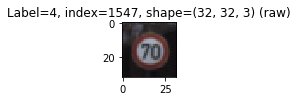

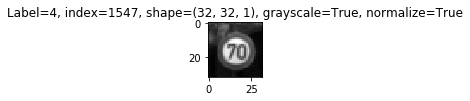

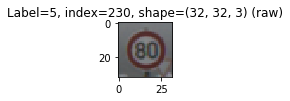

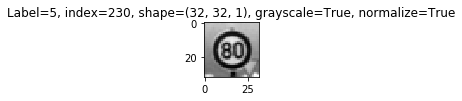

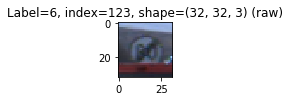

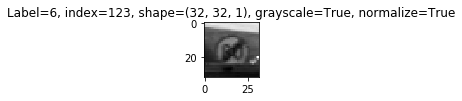

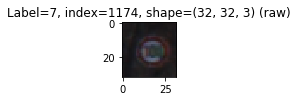

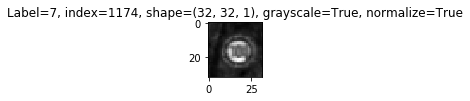

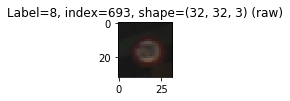

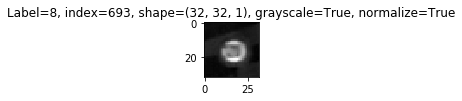

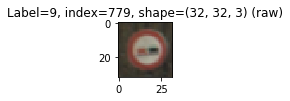

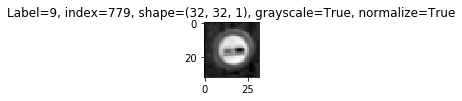

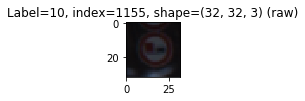

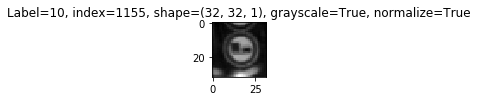

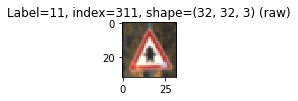

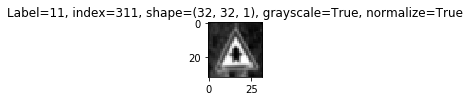

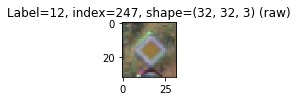

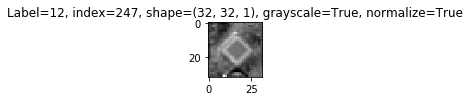

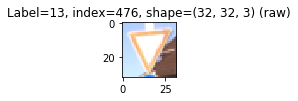

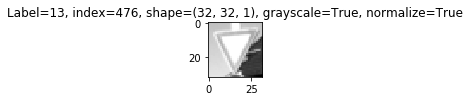

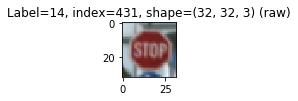

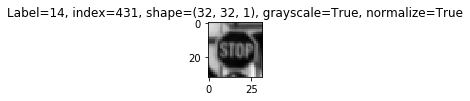

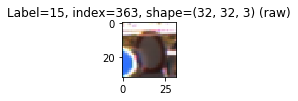

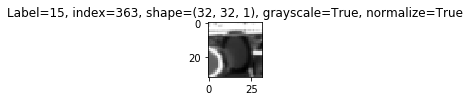

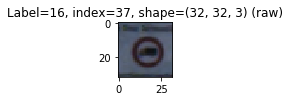

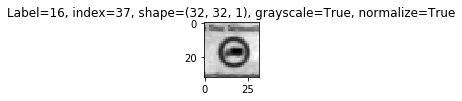

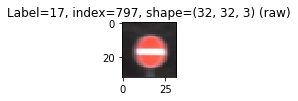

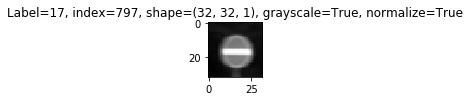

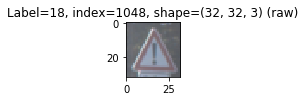

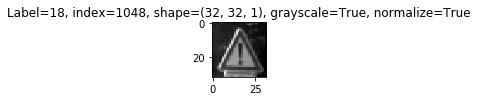

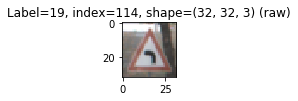

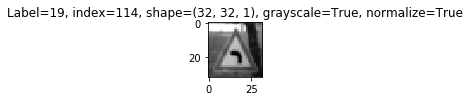

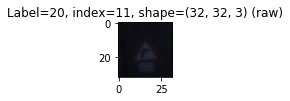

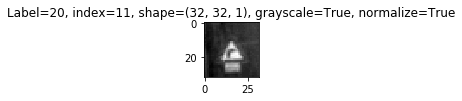

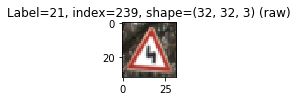

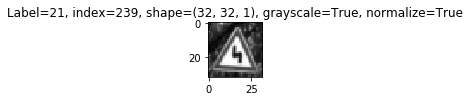

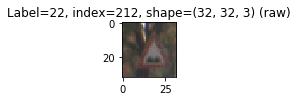

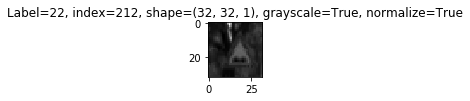

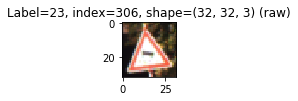

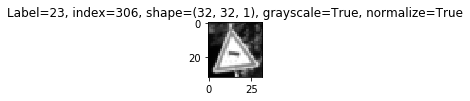

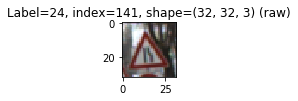

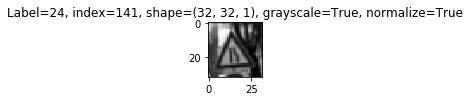

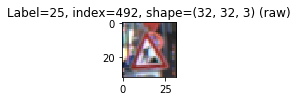

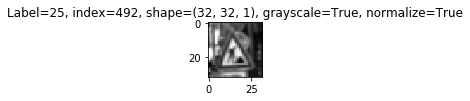

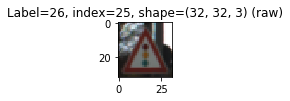

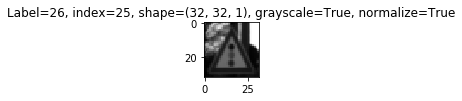

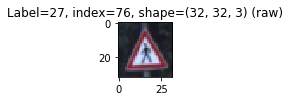

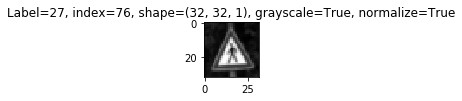

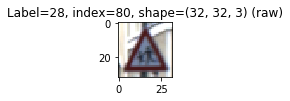

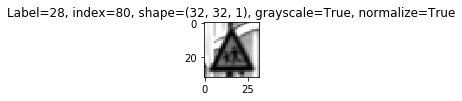

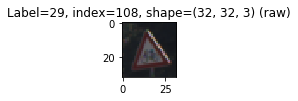

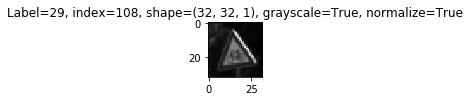

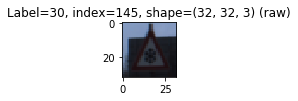

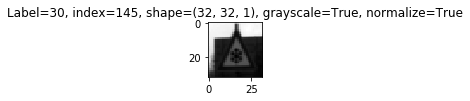

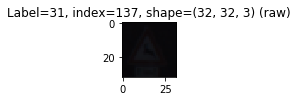

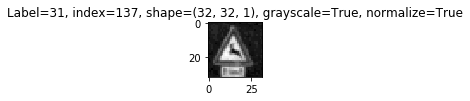

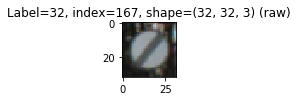

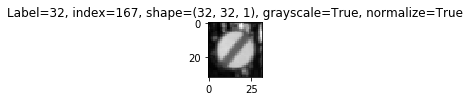

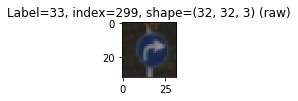

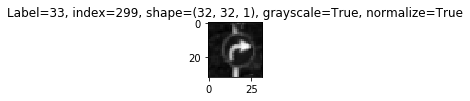

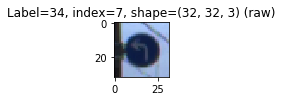

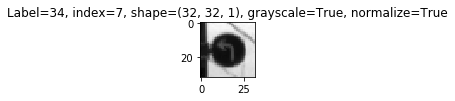

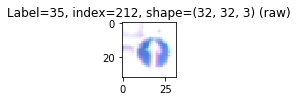

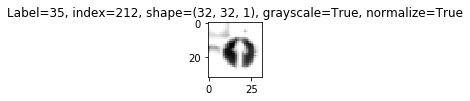

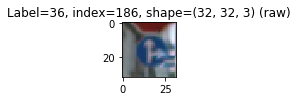

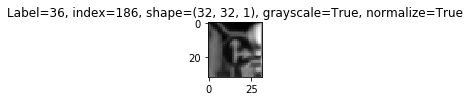

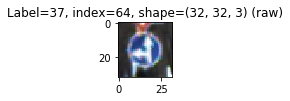

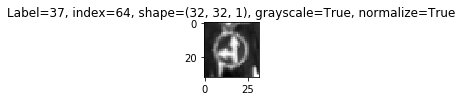

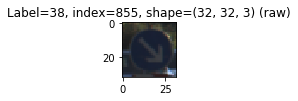

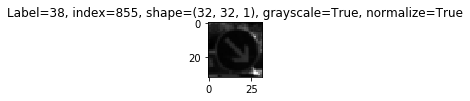

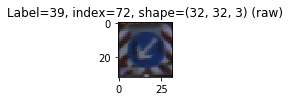

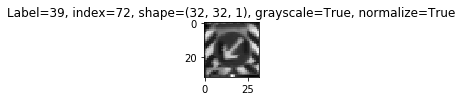

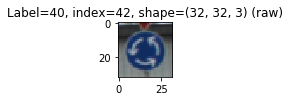

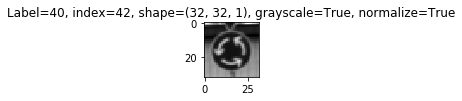

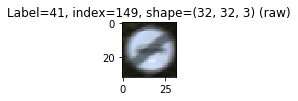

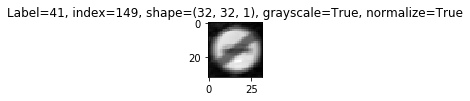

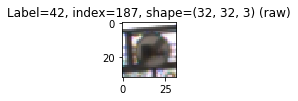

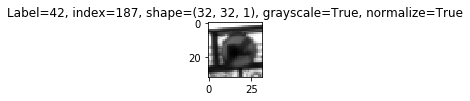

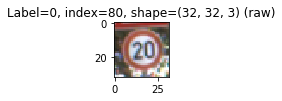

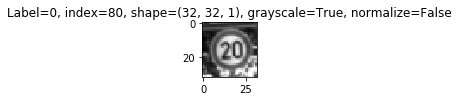

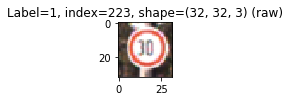

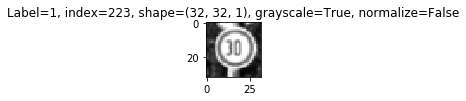

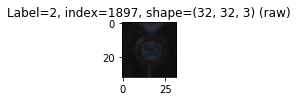

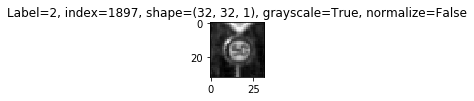

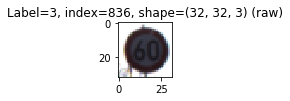

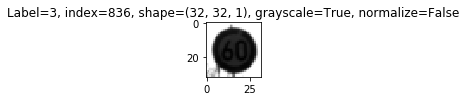

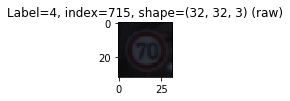

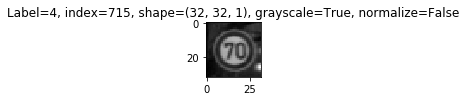

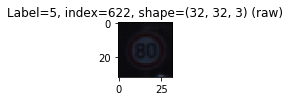

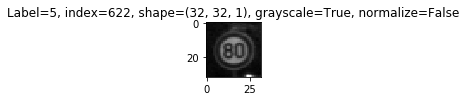

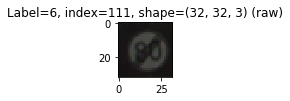

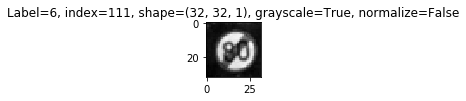

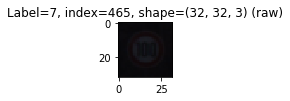

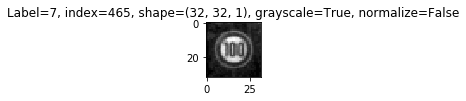

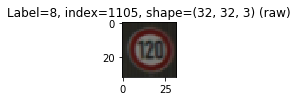

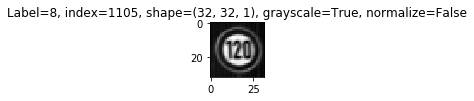

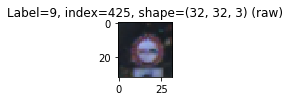

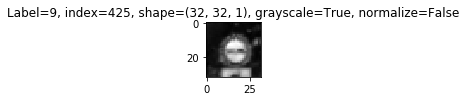

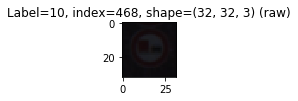

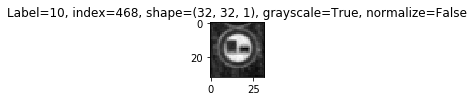

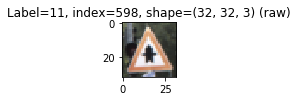

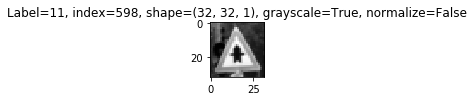

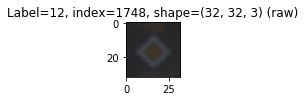

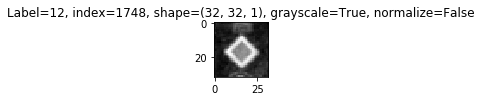

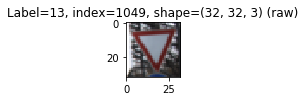

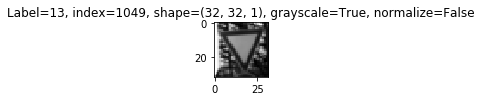

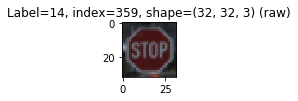

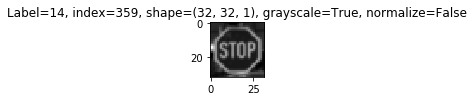

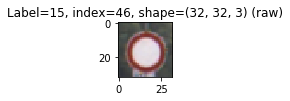

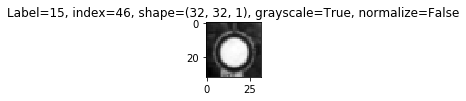

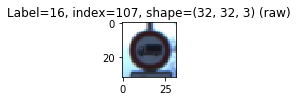

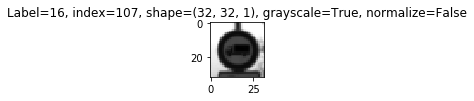

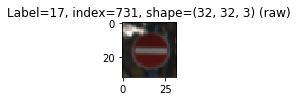

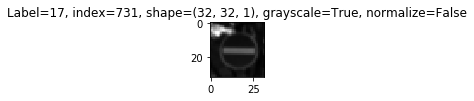

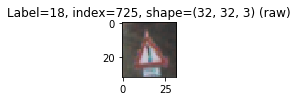

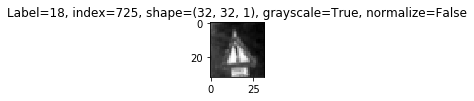

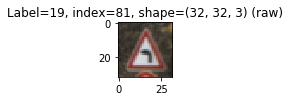

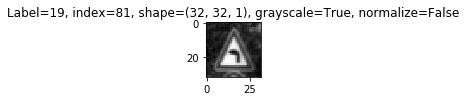

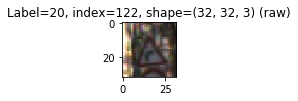

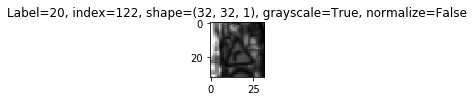

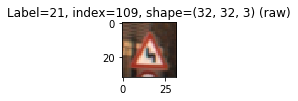

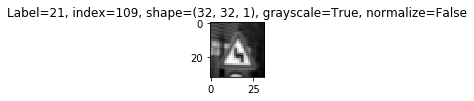

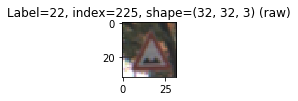

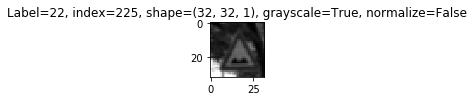

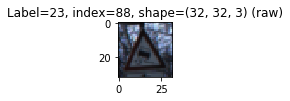

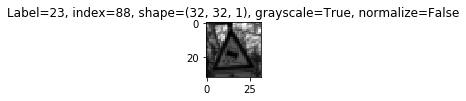

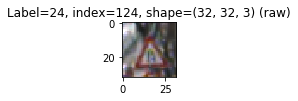

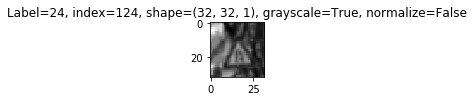

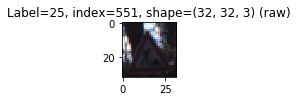

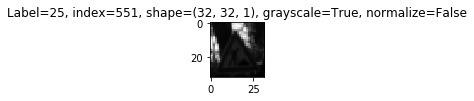

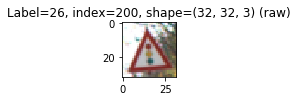

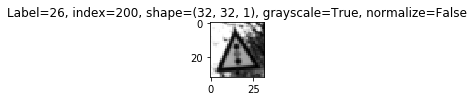

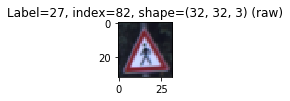

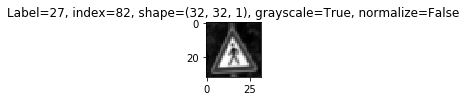

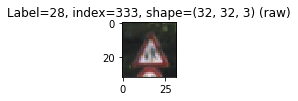

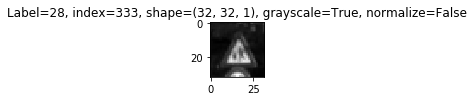

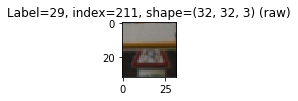

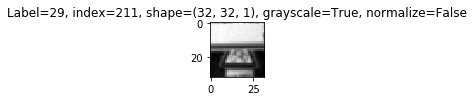

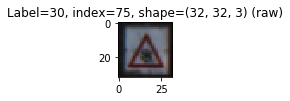

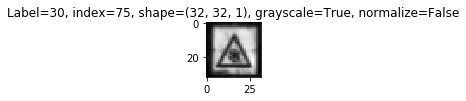

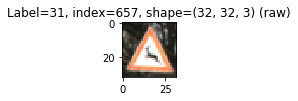

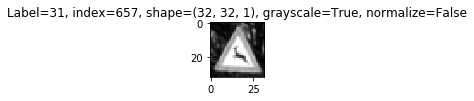

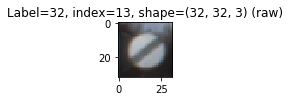

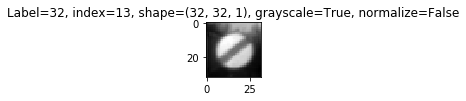

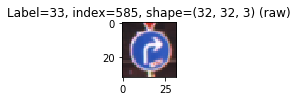

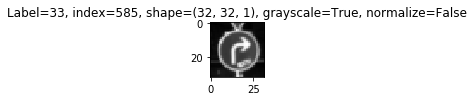

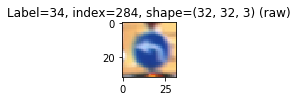

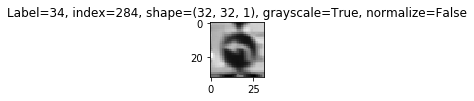

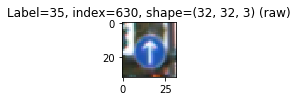

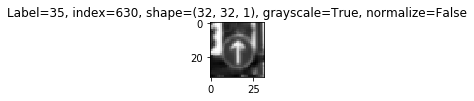

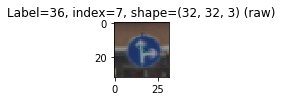

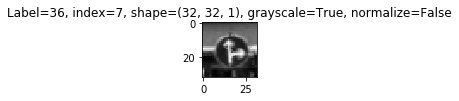

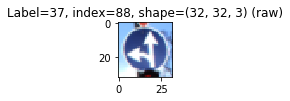

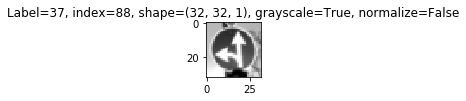

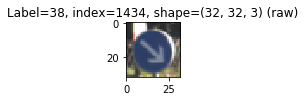

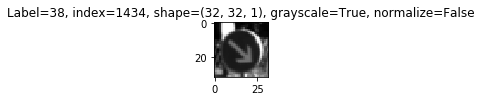

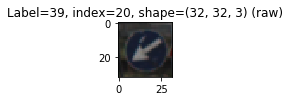

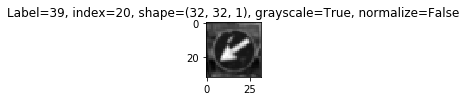

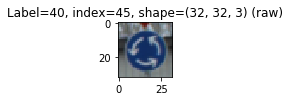

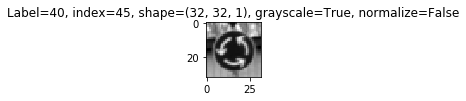

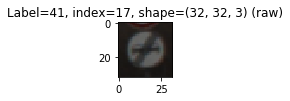

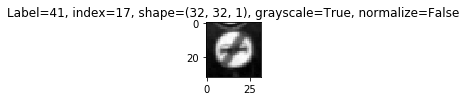

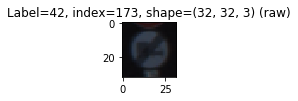

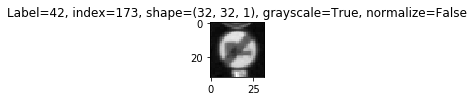

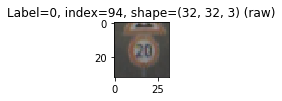

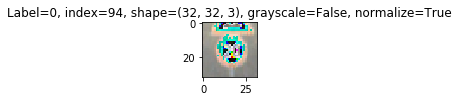

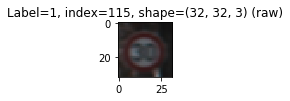

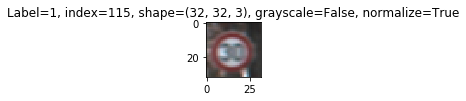

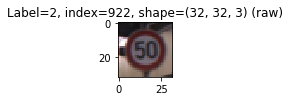

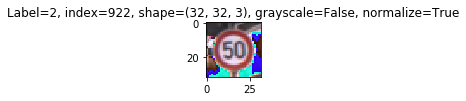

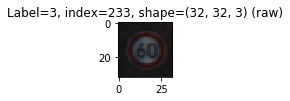

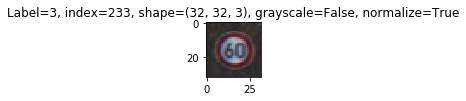

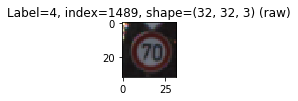

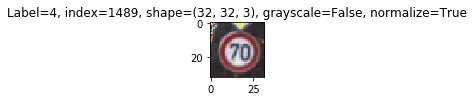

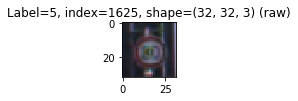

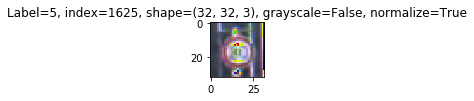

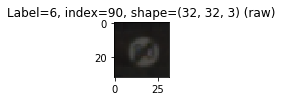

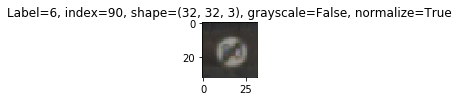

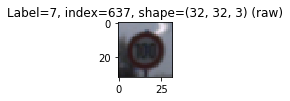

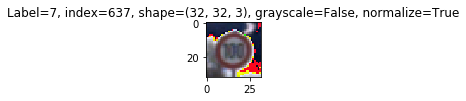

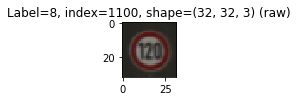

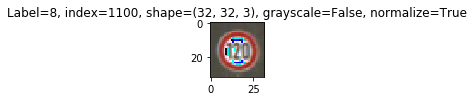

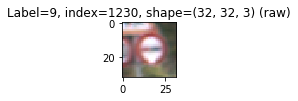

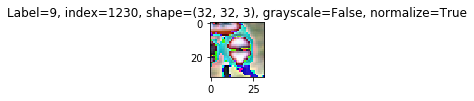

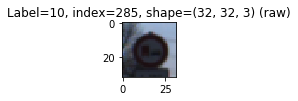

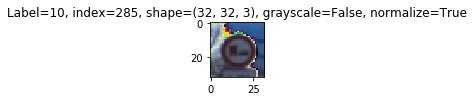

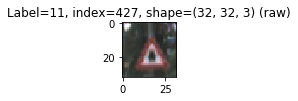

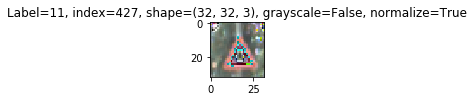

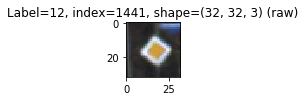

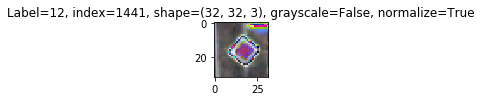

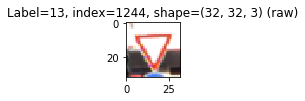

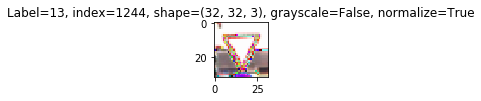

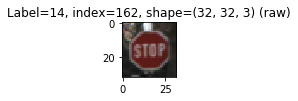

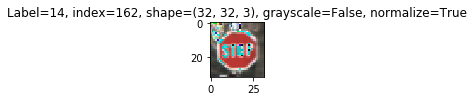

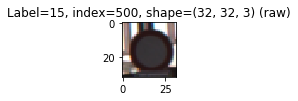

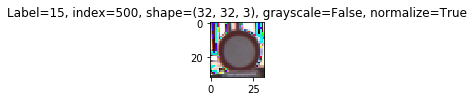

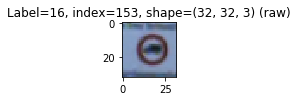

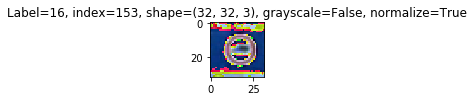

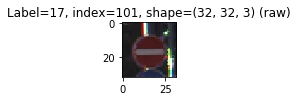

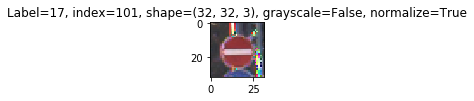

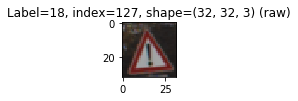

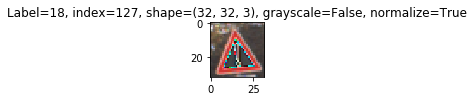

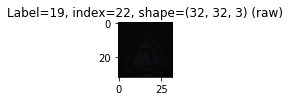

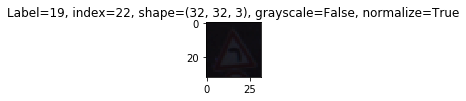

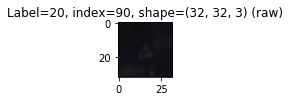

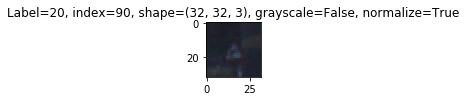

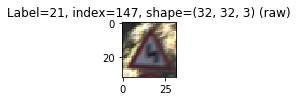

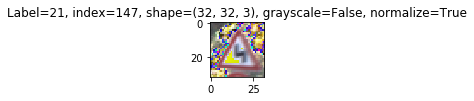

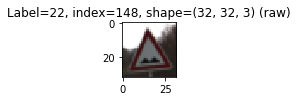

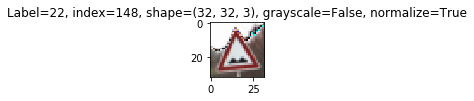

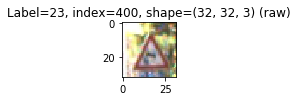

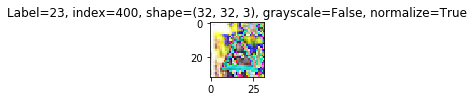

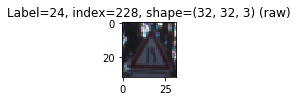

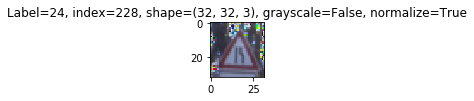

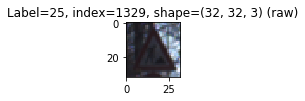

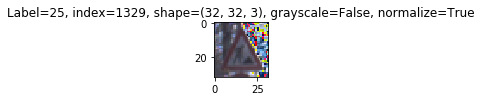

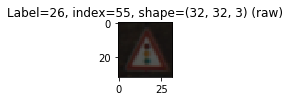

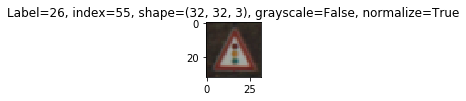

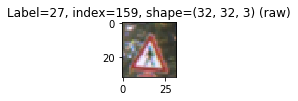

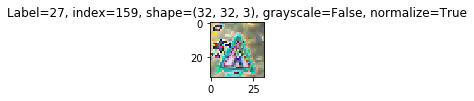

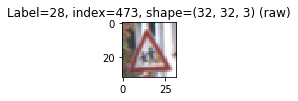

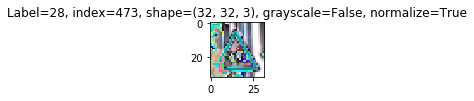

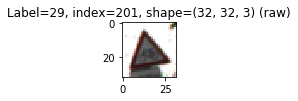

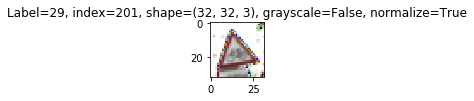

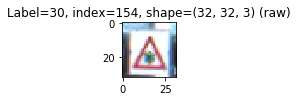

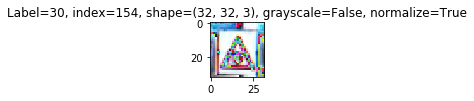

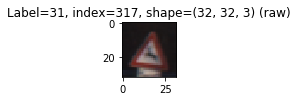

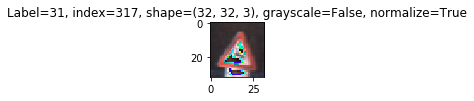

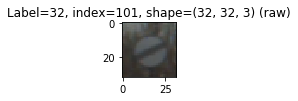

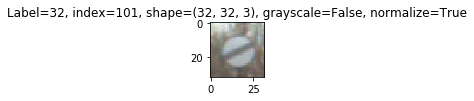

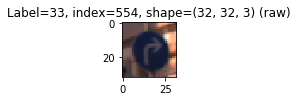

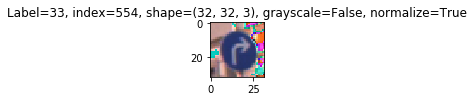

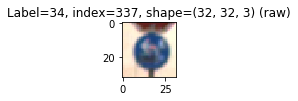

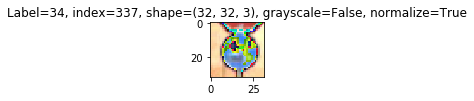

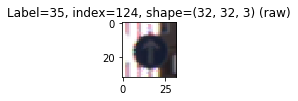

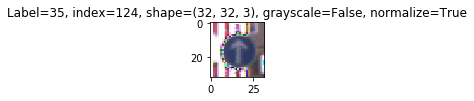

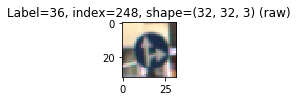

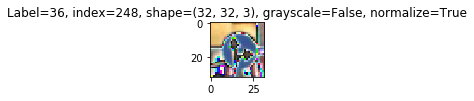

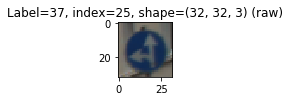

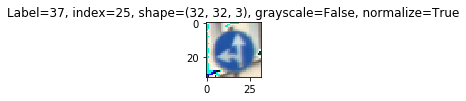

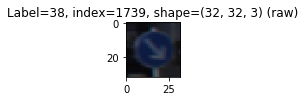

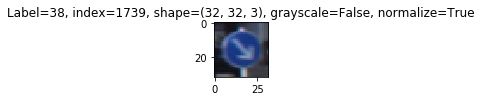

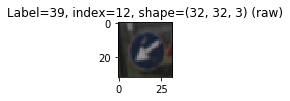

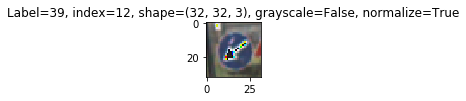

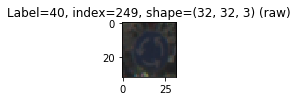

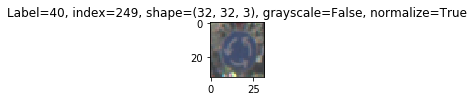

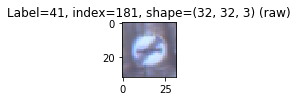

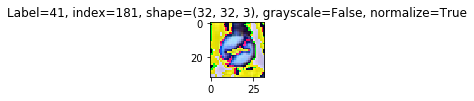

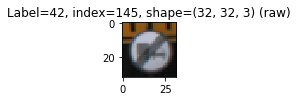

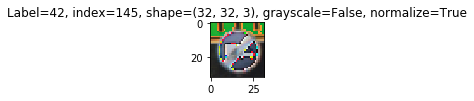

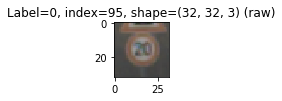

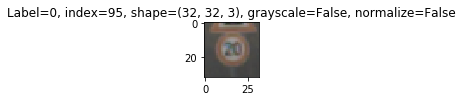

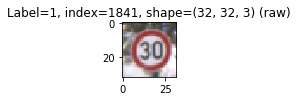

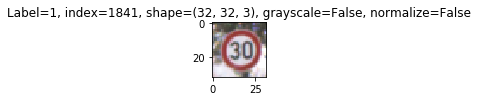

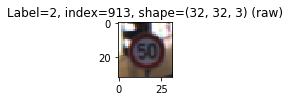

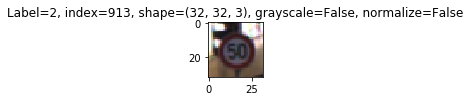

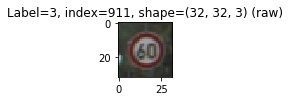

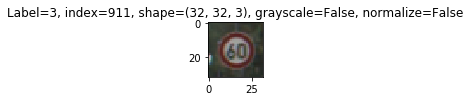

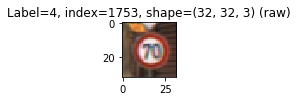

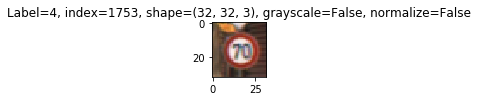

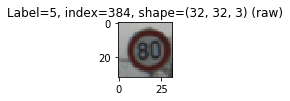

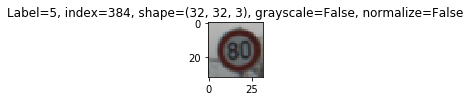

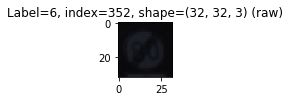

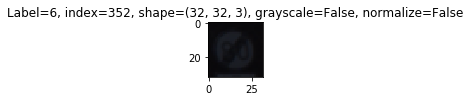

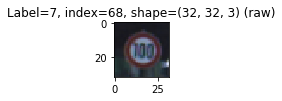

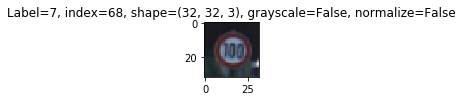

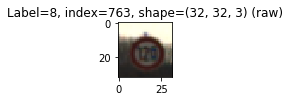

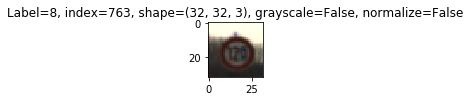

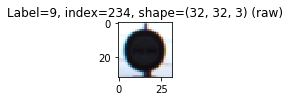

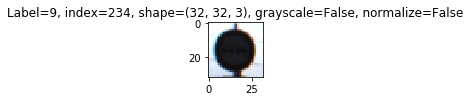

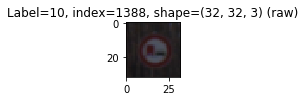

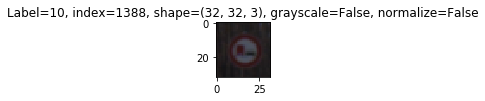

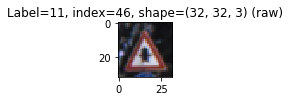

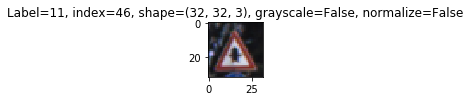

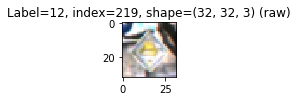

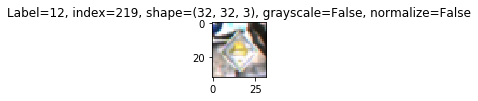

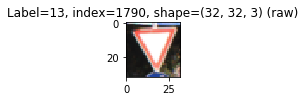

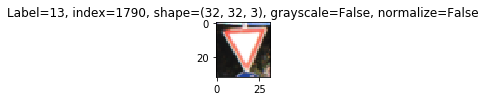

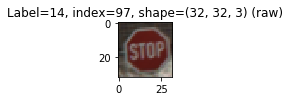

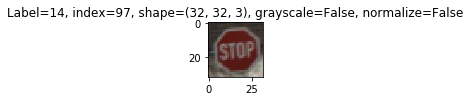

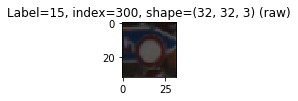

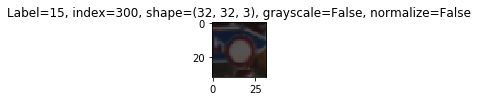

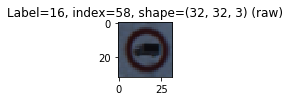

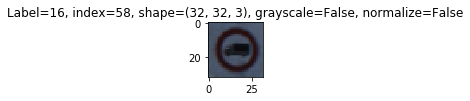

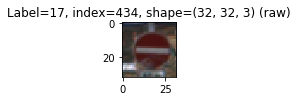

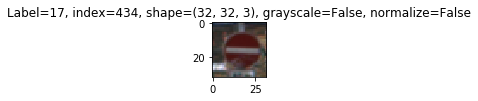

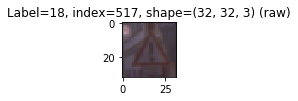

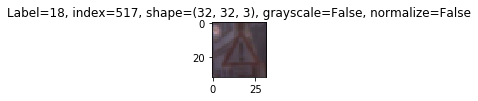

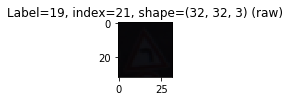

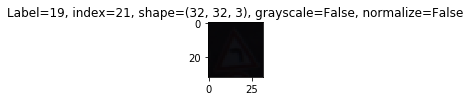

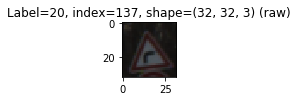

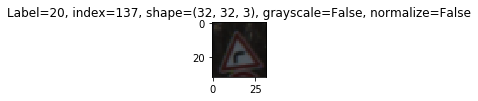

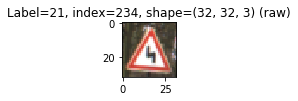

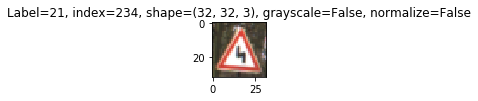

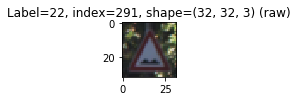

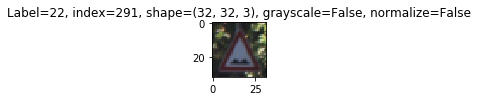

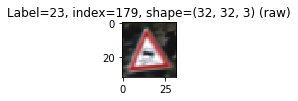

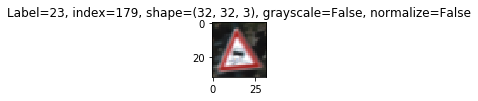

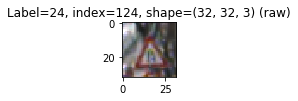

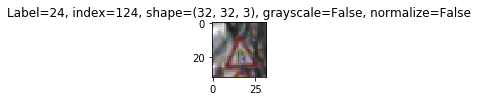

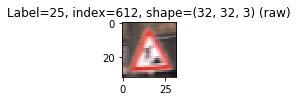

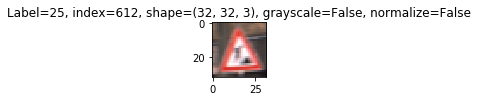

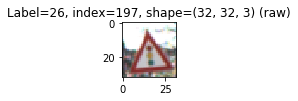

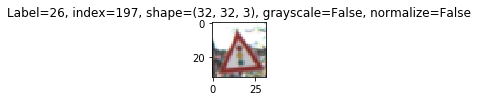

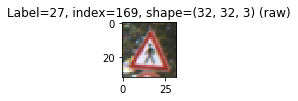

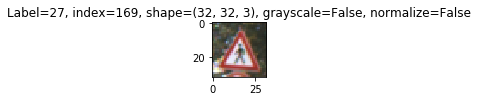

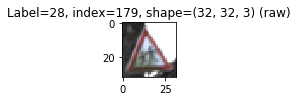

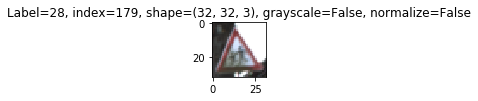

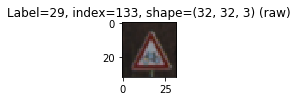

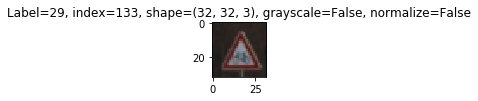

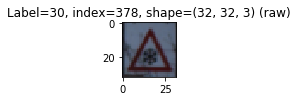

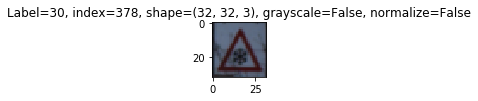

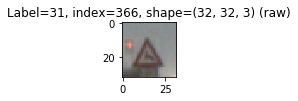

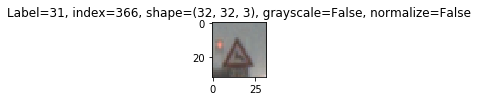

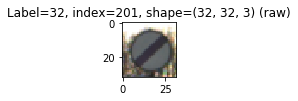

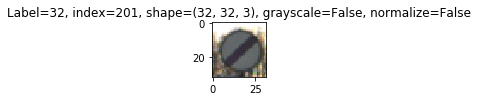

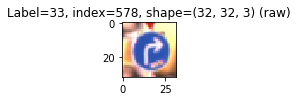

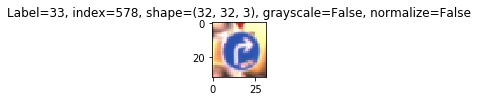

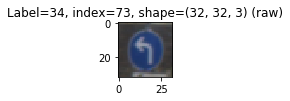

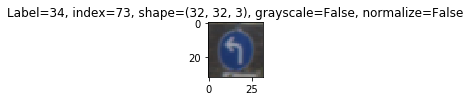

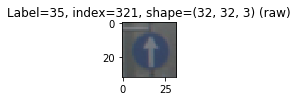

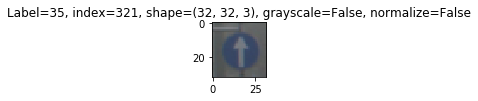

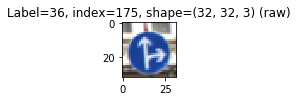

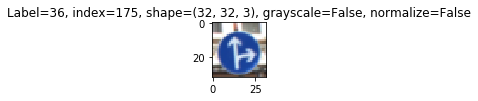

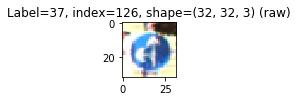

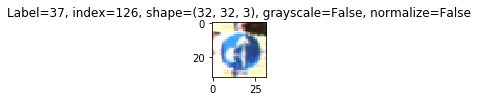

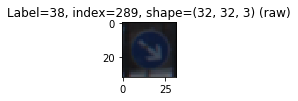

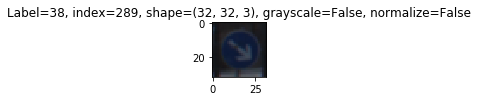

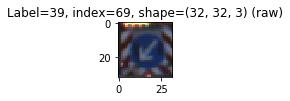

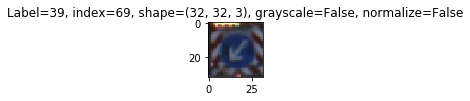

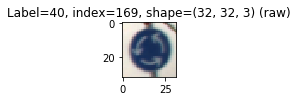

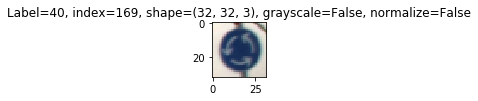

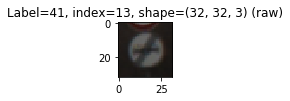

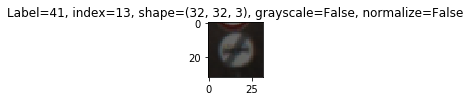

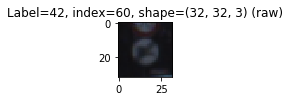

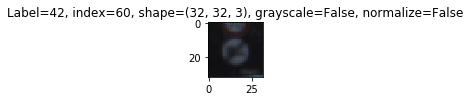

In [6]:
# Execute pre-processing on all sets and visualize samples 
from itertools import product

all_config = list(product(np.array([True,False]),
                          np.array([True,False])))

for curr_config in all_config:
    curr_grayscale = curr_config[0]
    curr_normalize = curr_config[1]

    # (1) Build images to display
    X_train_pre,X_valid_pre,X_test_pre,image_depth_pre,image_width,image_height = \
        build_images(X_train,X_valid,X_test,curr_grayscale,curr_normalize)

    # (2) Find samples to display
    dict_train_pre = defaultdict(list)
    for key, value in zip(y_train,X_train_pre):
        dict_train_pre[key].append(value)

    # (3) Display raw/pre-processed samples
    for key, value_pre in dict_train_pre.items():
        value_raw = dict_train_raw[key]    
        index = random.randint(0, (min(len(value_raw),len(value_pre))-1))

        image_raw = value_raw[index]
        image_pre = value_pre[index]

        plt.figure(figsize=(1,1))
        plt.imshow(image_raw.squeeze(), cmap="gray")
        plt.title("Label={}, index={}, shape={} (raw)".format(key,index,image_raw.shape))

        plt.figure(figsize=(1,1))
        plt.imshow(image_pre.squeeze(), cmap="gray")
        plt.title("Label={}, index={}, shape={}, grayscale={}, normalize={}".format(key,index,image_pre.shape,curr_grayscale,curr_normalize))


### Model Architecture

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def build_logits(x,curr_keep,curr_mu,curr_sigma,curr_conv1_depth,curr_conv2_depth):    
    """ Builds parameterized neural network model and returns key elements.
    """
    # Arguments used for tf.truncated_normal
    # randomly defines variables for the weights and biases for each layer
    keep = tf.placeholder_with_default(1.0,shape=(None), name="keep")
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth_pre, curr_conv1_depth), 
                                              mean = curr_mu, stddev = curr_sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(curr_conv1_depth), name="conv1_b")
    conv1   = tf.add(tf.nn.conv2d(x,conv1_W, strides=[1, 1, 1, 1], padding='VALID'),conv1_b)

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, curr_conv1_depth, curr_conv2_depth), 
                                              mean = curr_mu, stddev = curr_sigma),name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(curr_conv2_depth),name="conv2_b")
    conv2   = tf.add(tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID'),conv2_b)
    
    # Activation.
    conv2    = tf.nn.relu(conv2)
    # conv2    = tf.nn.dropout(conv2, curr_keep)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=((5*5*curr_conv2_depth), 120), 
                                              mean = curr_mu, stddev = curr_sigma),name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(120),name="fc1_b")
    fc1   = tf.add(tf.matmul(fc0, fc1_W),fc1_b)
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    # fc1    = tf.nn.dropout(fc1, curr_keep)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), 
                                              mean = curr_mu, stddev = curr_sigma),name="fc2_W")
    fc2_b  = tf.Variable(tf.zeros(84),name="fc2_b")
    fc2    = tf.add(tf.matmul(fc1, fc2_W),fc2_b)
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), 
                                              mean = curr_mu, stddev = curr_sigma),name="fc3_W")
    fc3_b  = tf.Variable(tf.zeros(n_classes),name="fc3_b")
    logits = tf.add(tf.matmul(fc2, fc3_W),fc3_b)
    
    return logits, keep, [conv1,conv2,fc1,fc2]

In [8]:
def build_classifier(curr_keep,curr_mu,curr_sigma,curr_rate,curr_conv1_depth,curr_conv2_depth):
    x_tensor = tf.placeholder(tf.float32, (None, image_width,image_height,image_depth_pre), name="x")
    y_tensor = tf.placeholder(tf.int32, (None), name="y")
    
    one_hot_y = tf.one_hot(y_tensor,n_classes)
    logits,keep_tensor,activation_layers = \
        build_logits(x_tensor,curr_keep,curr_mu,curr_sigma,curr_conv1_depth,curr_conv2_depth)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=curr_rate)
    
    training_operation = optimizer.minimize(loss_operation)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return x_tensor,y_tensor,logits,keep_tensor,activation_layers,training_operation,accuracy_operation

In [9]:
def train_classifier(x_tensor,y_tensor,keep_tensor,training_operation,X_data,y_data,curr_batch):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0,num_examples,curr_batch):
        end = offset+curr_batch
        batch_x, batch_y = X_data[offset:end],y_data[offset:end]
        sess.run(training_operation, \
                 feed_dict={x_tensor:batch_x,y_tensor:batch_y,keep_tensor:curr_keep})

In [10]:
def evaluate_classifier(x_tensor,y_tensor,keep_tensor,accuracy_operation,X_data,y_data,curr_batch):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0,num_examples,curr_batch):
        end = offset+curr_batch
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, \
                feed_dict={x_tensor:batch_x,y_tensor:batch_y,keep_tensor:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.    
from sklearn.utils import shuffle
from operator import itemgetter

default_mu = 0.0
default_sigma = 0.1
default_rate = 0.001
default_epochs = 10
default_keep = 0.5
default_batch_size = 128

# Initial values

# mu_range = np.array([default_mu])
# sigma_range = np.array([default_sigma])
# rate_range = np.array([default_rate])
# epochs_range = np.array([default_epochs])
# keep_range = np.array([default_keep])
# batch_size_range = np.array([default_batch_size])

# Best, single values found

found_mu = 0.0
found_sigma = 0.1
found_rate = 0.0013
found_epochs = 100
found_keep = 0.5
found_batch_size = 128
found_grayscale = True
found_normalize = True
found_conv1_depth = 24
found_conv2_depth = 64

mu_range = np.array([found_mu])
sigma_range = np.array([found_sigma])
rate_range = np.array([found_rate])
epochs_range = np.array([found_epochs])
keep_range = np.array([found_keep])
batch_size_range = np.array([found_batch_size])
grayscale_range = np.array([found_grayscale])
normalize_range = np.array([found_normalize])
conv1_depth_range = np.array([found_conv1_depth])
conv2_depth_range = np.array([found_conv2_depth])

# Ranges for searching

# mu_range = np.arange(-10.0,11.0,10.0)
# sigma_range = np.arange(0.1,1.0,0.4)
# rate_range = np.arange(0.0007,0.0014,0.0003)
# epochs_range = np.arange(10,41,15)
# keep_range = np.arange(0.5,1.1,0.25)
# batch_size_range = np.arange(64,193,64)
# grayscale_range = np.array([True,False])
# normalize_range = np.array([True,False])
# conv1_depth_range = np.array([6,16,24])
# conv2_depth_range = np.array([16,40,64])

best_accuracy = 0.0
best_epochs = 0

all_config = list(product(mu_range,sigma_range,
                            rate_range,epochs_range,
                            keep_range,batch_size_range,
                            grayscale_range,normalize_range,
                            conv1_depth_range,conv2_depth_range))
all_accuracy = []
all_work_config = []

n_tries = 3
n_permutations=len(all_config)
n_passes = (n_tries*n_permutations)
pass_ctr = 0
print ('Total passes {} (tries={}, permutations={}):'.format(n_passes,n_tries,n_permutations))

for curr_try in range(n_tries):
    random.shuffle(all_config)
    for curr_config in all_config:
        work_config = list(curr_config)

        curr_mu = work_config[0]
        curr_sigma = work_config[1]
        curr_rate = work_config[2]
        curr_epochs = work_config[3]
        curr_keep = work_config[4]
        curr_batch_size = work_config[5]
        curr_grayscale = work_config[6]
        curr_normalize = work_config[7]
        curr_conv1_depth = work_config[8]
        curr_conv2_depth = work_config[9]

        tf.reset_default_graph()
        X_train_pre,X_valid_pre,X_test_pre,image_depth_pre,image_width,image_height = \
            build_images(X_train,X_valid,X_test,curr_grayscale,curr_normalize)
        y_train_pre = np.copy(y_train)
        y_valid_pre = np.copy(y_valid)
        y_test_pre = np.copy(y_test)
        
        x_tensor,y_tensor,logits,keep_tensor,activation_layers,training_operation,accuracy_operation = \
            build_classifier(curr_keep,curr_mu,curr_sigma,curr_rate,curr_conv1_depth,curr_conv2_depth)
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            pass_ctr = (pass_ctr+1)

            max_accuracy = 0.0
            max_accuracy_epochs = 0
            curr_accuracy = 0.0
            bad_accuracy_ctr = 0
            max_bad_accuracy = max(5,(curr_epochs/5))

            print("Current pass #", pass_ctr, "of", n_passes)
            print("    curr_mu: ", curr_mu)
            print("    curr_sigma: ", curr_sigma)
            print("    curr_rate: ", curr_rate)
            print("    curr_epochs: ", curr_epochs)
            print("    curr_keep: ", curr_keep)
            print("    curr_batch_size: ", curr_batch_size)
            print("    curr_grayscale: ", curr_grayscale)
            print("    curr_normalize: ", curr_normalize)
            print("    curr_conv1_depth: ", curr_conv1_depth)
            print("    curr_conv2_depth: ", curr_conv2_depth)

            sess.run(tf.global_variables_initializer())
            for i in range(curr_epochs):
                # shuffle & train
                X_train_pre,y_train_pre = shuffle(X_train_pre,y_train_pre)
                train_classifier(x_tensor,y_tensor,keep_tensor,training_operation,X_train_pre,y_train_pre,curr_batch_size)

                # evaulate vs known values
                X_valid_pre,y_valid_pre = shuffle(X_valid_pre,y_valid_pre)
                curr_accuracy = evaluate_classifier(x_tensor,y_tensor,keep_tensor,accuracy_operation,X_valid_pre,y_valid_pre,curr_batch_size)

                # check for best model (always save)
                if curr_accuracy > best_accuracy or \
                    (curr_accuracy == best_accuracy and i < best_epochs):
                        # track best
                        best_accuracy = curr_accuracy
                        best_epochs = i

                        # save best
                        saver.save(sess, './lenet')

                # check for early termination
                if curr_accuracy < max_accuracy:
                    bad_accuracy_ctr = (bad_accuracy_ctr+1)
                    if bad_accuracy_ctr > max_bad_accuracy:
                        print("Stopping at epoch #", i, "(degrading accuracy)!")
                        break
                else:
                    bad_accuracy_ctr = 0
                    max_accuracy = max(max_accuracy,curr_accuracy)
                    max_accuracy_epochs = i

            # update config w/actual epochs
            # (in case of early term)
            work_config[3] = max_accuracy_epochs

            # track
            all_accuracy.append(max_accuracy)
            all_work_config.append(work_config)

            print("Accuracy (Validation) = {:.3f}".format(max_accuracy))
            print ()

sorted_output = \
    [list(x) for x in zip(*sorted(zip(all_accuracy, all_work_config), key=itemgetter(0), reverse=True))] 
max_output = min(10,len(sorted_output[0]))
    
print ("Top", max_output, "results:")
for index in range(0,max_output):
    print ("Accuracy = {:.3f}".format(sorted_output[0][index]),"/ Config =",sorted_output[1][index])


Total passes 3 (tries=3, permutations=1):
Current pass # 1 of 3
    curr_mu:  0.0
    curr_sigma:  0.1
    curr_rate:  0.0013
    curr_epochs:  100
    curr_keep:  0.5
    curr_batch_size:  128
    curr_grayscale:  True
    curr_normalize:  True
    curr_conv1_depth:  24
    curr_conv2_depth:  64
Stopping at epoch # 61 (degrading accuracy)!
Accuracy (Validation) = 0.971

Current pass # 2 of 3
    curr_mu:  0.0
    curr_sigma:  0.1
    curr_rate:  0.0013
    curr_epochs:  100
    curr_keep:  0.5
    curr_batch_size:  128
    curr_grayscale:  True
    curr_normalize:  True
    curr_conv1_depth:  24
    curr_conv2_depth:  64
Stopping at epoch # 44 (degrading accuracy)!
Accuracy (Validation) = 0.972

Current pass # 3 of 3
    curr_mu:  0.0
    curr_sigma:  0.1
    curr_rate:  0.0013
    curr_epochs:  100
    curr_keep:  0.5
    curr_batch_size:  128
    curr_grayscale:  True
    curr_normalize:  True
    curr_conv1_depth:  24
    curr_conv2_depth:  64
Stopping at epoch # 54 (degrading accu

In [12]:
X_train_pre,X_valid_pre,X_test_pre,image_depth_pre,image_width,image_height = \
    build_images(X_train,X_valid,X_test,found_grayscale,found_normalize)
y_train_pre = np.copy(y_train)
y_valid_pre = np.copy(y_valid)
y_test_pre = np.copy(y_test)

tf.reset_default_graph()
x_tensor,y_tensor,logits,keep_tensor,activation_layers,training_operation,accuracy_operation = \
    build_classifier(found_keep,found_mu,found_sigma,found_rate,found_conv1_depth,found_conv2_depth)

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, './lenet')

    X_test_pre,y_test_pre = shuffle(X_test_pre, y_test_pre)
    test_accuracy = evaluate_classifier(x_tensor,y_tensor,keep_tensor,accuracy_operation,X_test_pre,y_test_pre,found_batch_size)

    print("Accuracy (Test) =", test_accuracy)

Accuracy (Test) = 0.9505146474


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

input_data/real_signs/label-17.png = (32, 32, 3)
input_data/real_signs/label-7.png = (32, 32, 3)
input_data/real_signs/label-13.png = (32, 32, 3)
input_data/real_signs/label-35.png = (32, 32, 3)
input_data/real_signs/label-1.png = (32, 32, 3)
input_data/real_signs/label-5.png = (32, 32, 3)
input_data/real_signs/label-2.png = (32, 32, 3)
input_data/real_signs/label-22.png = (32, 32, 3)
input_data/real_signs/label-33.png = (32, 32, 3)
input_data/real_signs/label-25.png = (32, 32, 3)


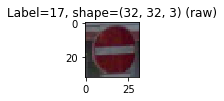

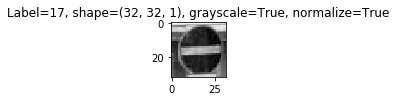

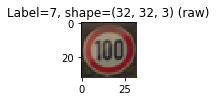

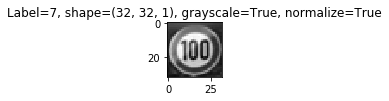

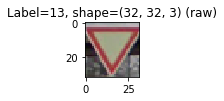

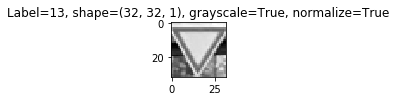

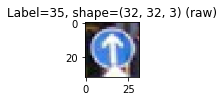

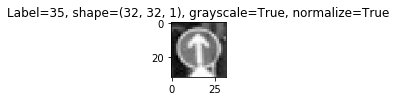

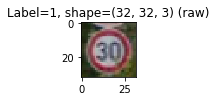

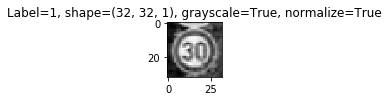

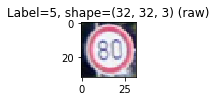

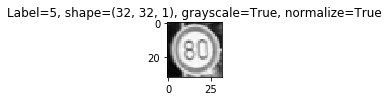

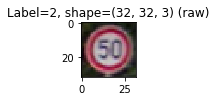

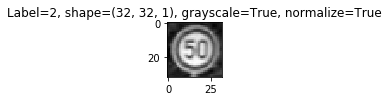

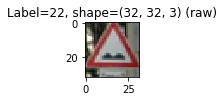

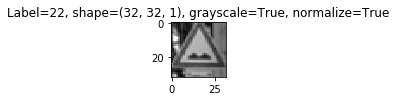

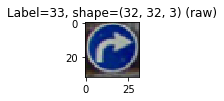

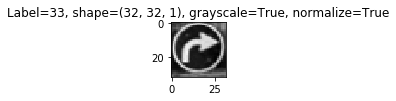

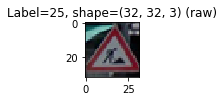

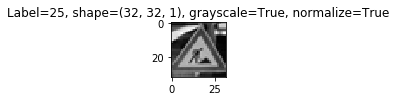

In [13]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import os
import re
import matplotlib.pyplot as plt
import cv2

X_real = []
y_real = []

for image_file in glob.glob("input_data/real_signs/label-*.png"):
    file_parts = re.split("-|\.",os.path.basename(image_file))
    image_data = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    image_label = int(file_parts[1])
    
    print (image_file, "=", image_data.shape)
    X_real.append(image_data)
    y_real.append(image_label)
    
X_real_pre = pre_process_images(np.array(X_real),found_grayscale,found_normalize)
y_real_pre = np.array(y_real)

for index in range(min(len(X_real),len(y_real))):
    key = y_real[index]
    image_raw = X_real[index]
    image_pre = X_real_pre[index]
    
    plt.figure(figsize=(1,1))
    plt.imshow(image_raw.squeeze(), cmap="gray")
    plt.title("Label={}, shape={} (raw)".format(key,image_raw.shape))

    plt.figure(figsize=(1,1))
    plt.imshow(image_pre.squeeze(), cmap="gray")
    plt.title("Label={}, shape={}, grayscale={}, normalize={}".format(key,image_pre.shape,found_grayscale,found_normalize))

X_real_pre, y_real_pre = shuffle(X_real_pre, y_real_pre)


### Predict the Sign Type for Each Image & Analyze Performance

Accuracy (Real) = 0.800


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


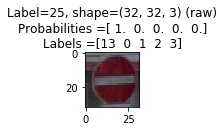

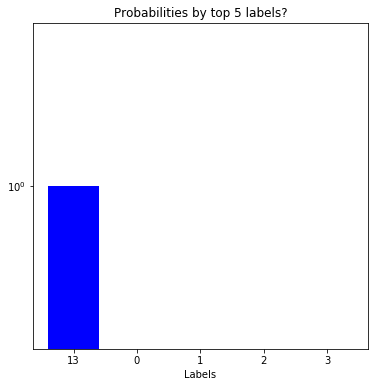

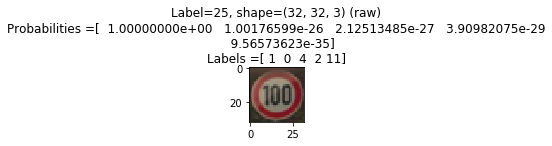

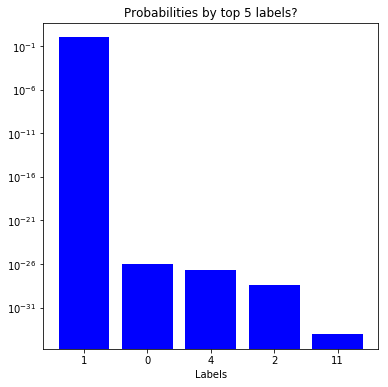

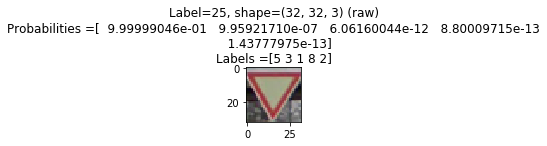

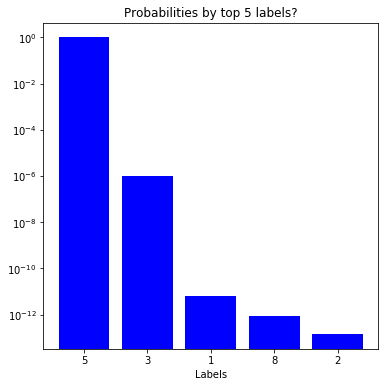

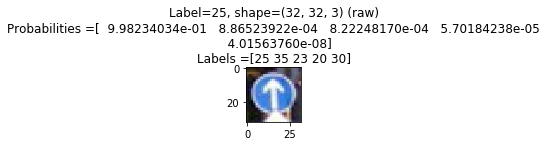

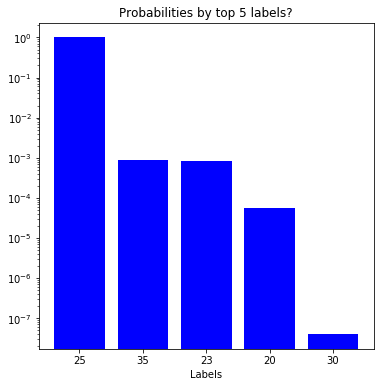

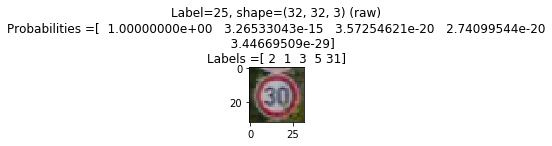

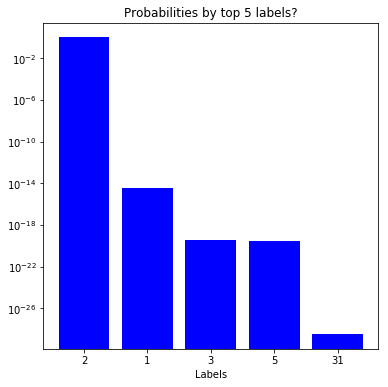

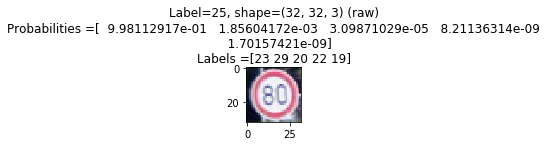

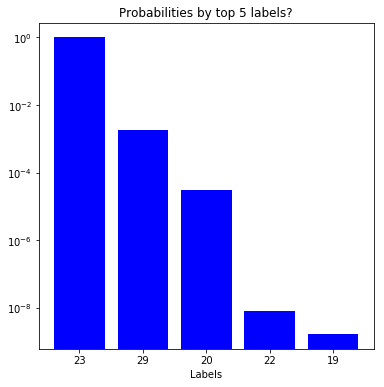

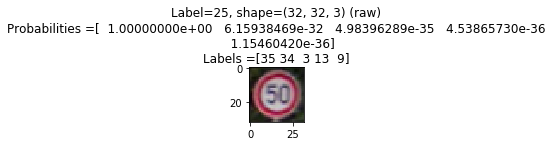

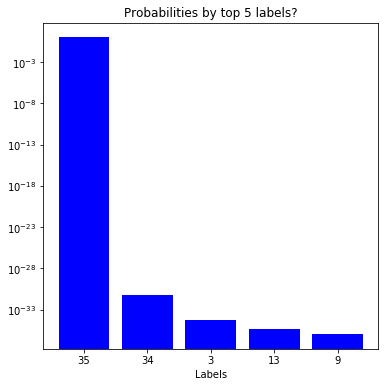

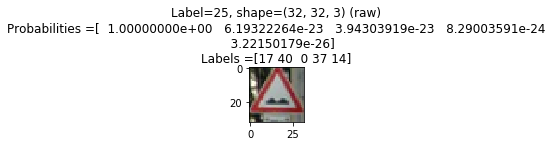

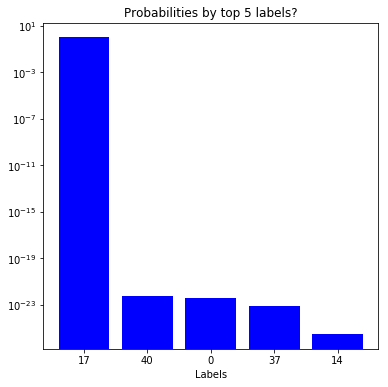

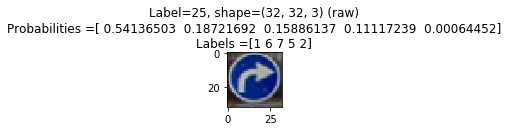

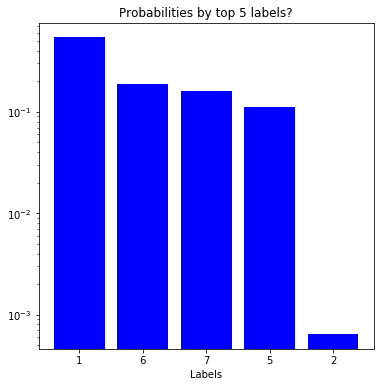

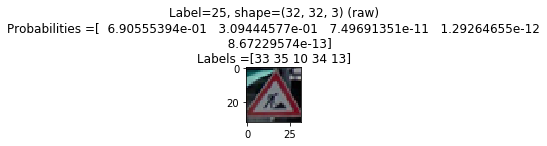

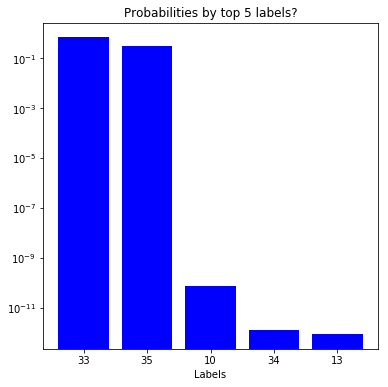

In [14]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
tf.reset_default_graph()
x_tensor,y_tensor,logits,keep_tensor,activation_layers,training_operation,accuracy_operation = \
    build_classifier(found_keep,found_mu,found_sigma,found_rate,found_conv1_depth,found_conv2_depth)
softmax = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, './lenet')

    X_real_pre,y_real_pre = shuffle(X_real_pre,y_real_pre)
    real_probability = sess.run(softmax, \
                        feed_dict={x_tensor:X_real_pre,y_tensor:y_real_pre,keep_tensor:1.0})
    real_top_k = sess.run(tf.nn.top_k(tf.constant(real_probability),5), \
                        feed_dict={x_tensor:X_real_pre,y_tensor:y_real_pre,keep_tensor:1.0})
    
    real_accuracy = evaluate_classifier(x_tensor,y_tensor,keep_tensor,accuracy_operation,X_real_pre,y_real_pre,found_batch_size)
    print("Accuracy (Real) = {:.3f}".format(real_accuracy))

for index in range(min(len(X_real),len(y_real))):
    real_label = y_real[index]
    real_image = X_real[index]
    
    found_probabilities = real_top_k.values[index]
    found_labels = real_top_k.indices[index]
    
    plt.figure(figsize=(1,1))
    plt.imshow(real_image.squeeze(), cmap="gray")
    plt.title("Label={}, shape={} (raw)".format(key,real_image.shape) + "\n" \
            + "Probabilities =" + str(found_probabilities) + "\n" \
            + "Labels =" + str(found_labels))
    
    fig,ax = plt.subplots(figsize=(6, 6))
    ax.bar(np.arange(len(found_probabilities)), found_probabilities, align='center', 
            color='blue', ecolor='black')
    ax.set_xticks(np.arange(len(found_labels)))
    ax.set_xticklabels(found_labels)
    ax.set_yscale('log')
    ax.set_xlabel('Labels')
    ax.set_title('Probabilities by top 5 labels?')

    plt.show()



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [15]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


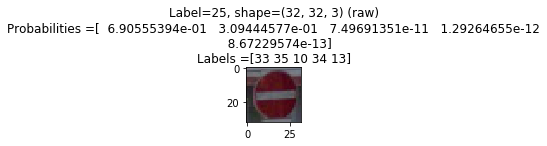

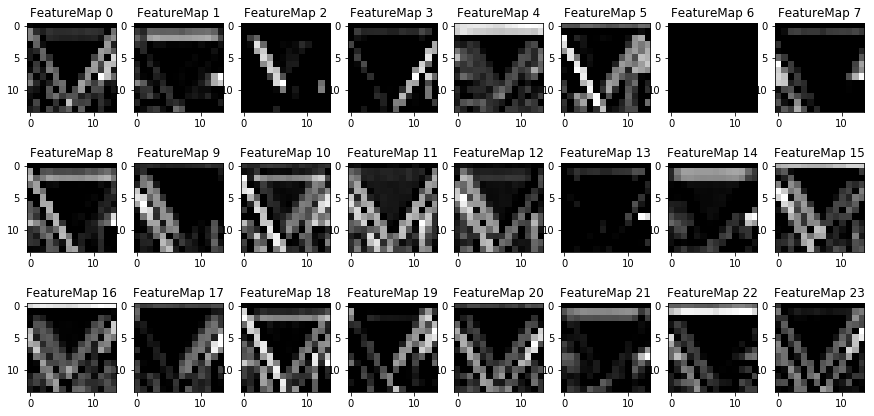

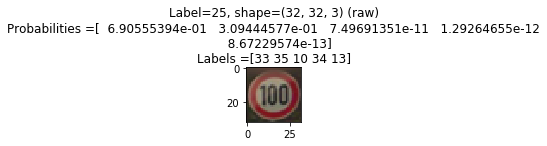

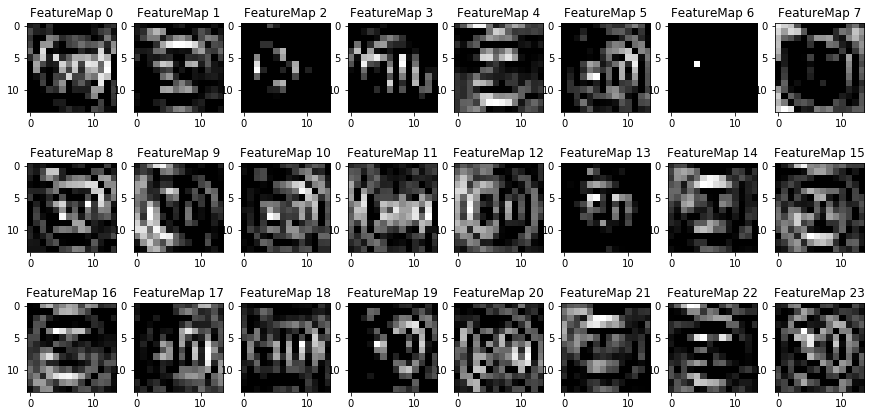

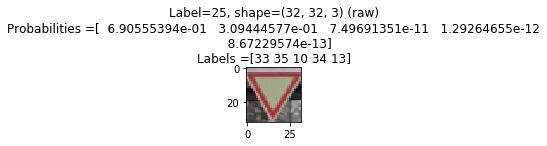

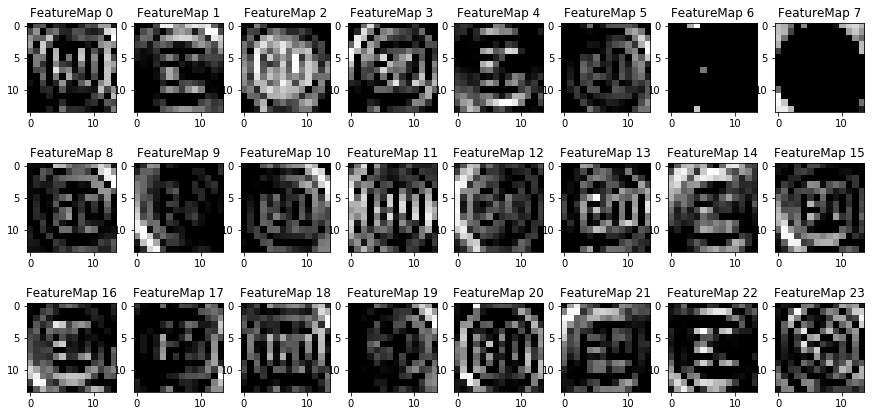

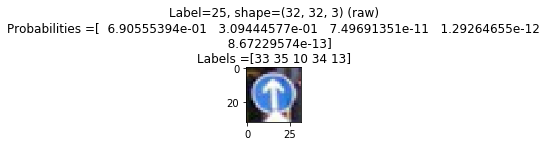

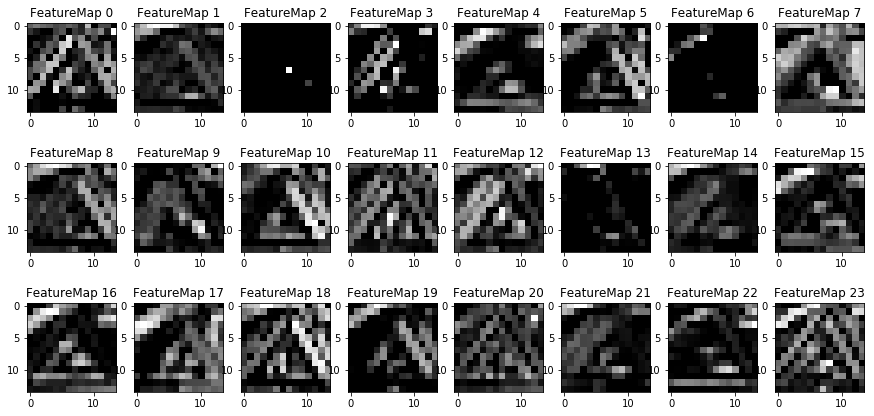

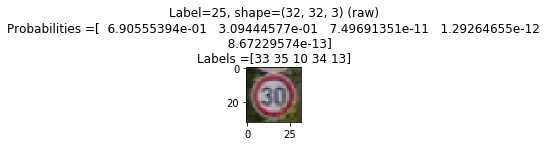

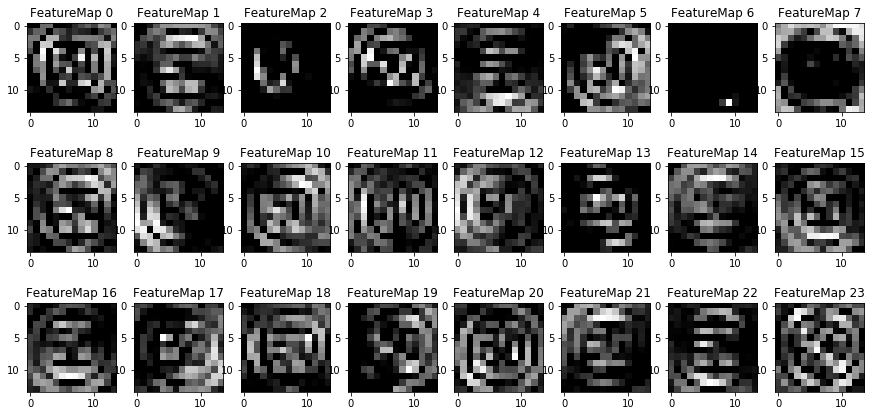

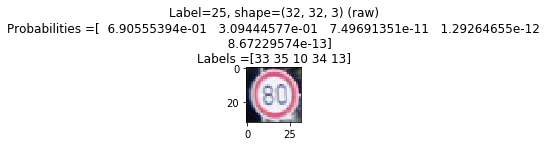

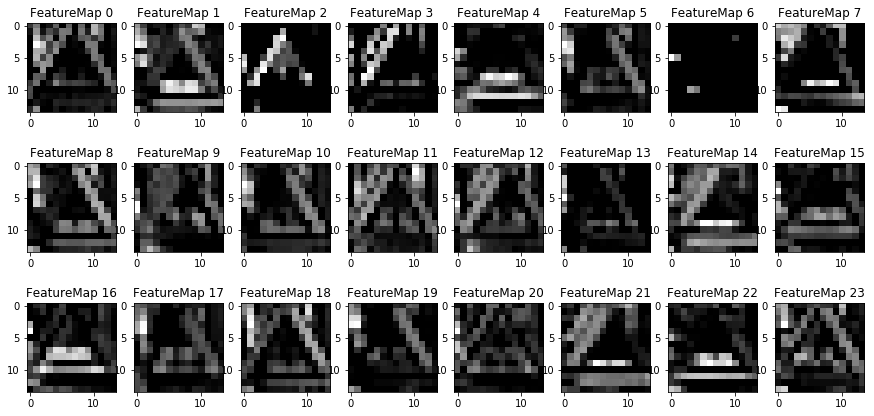

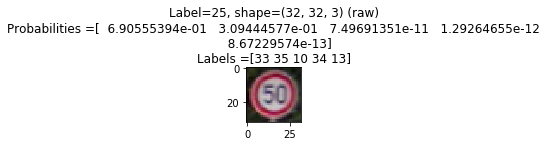

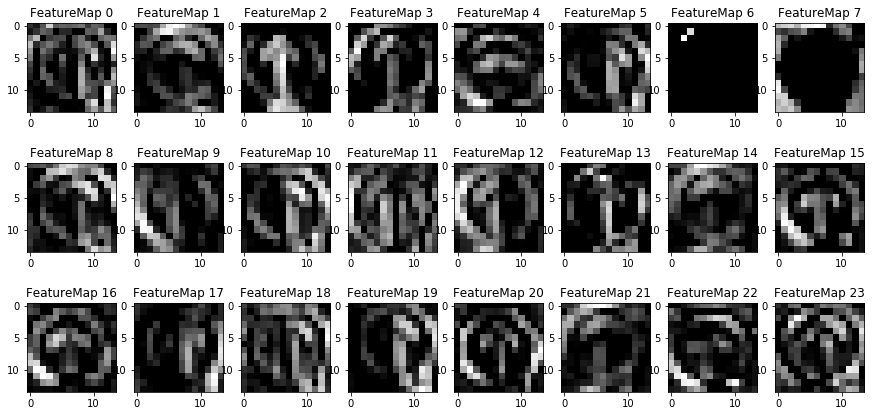

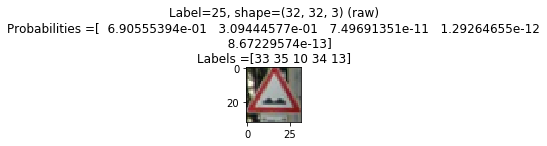

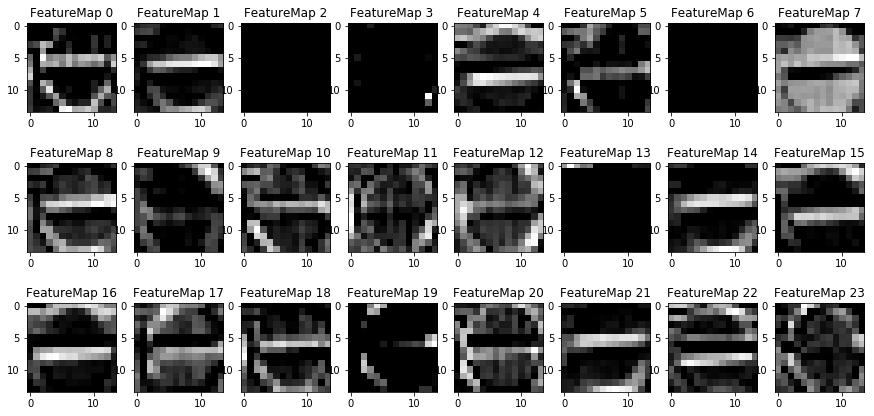

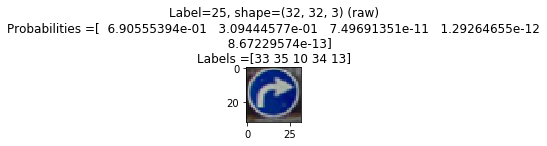

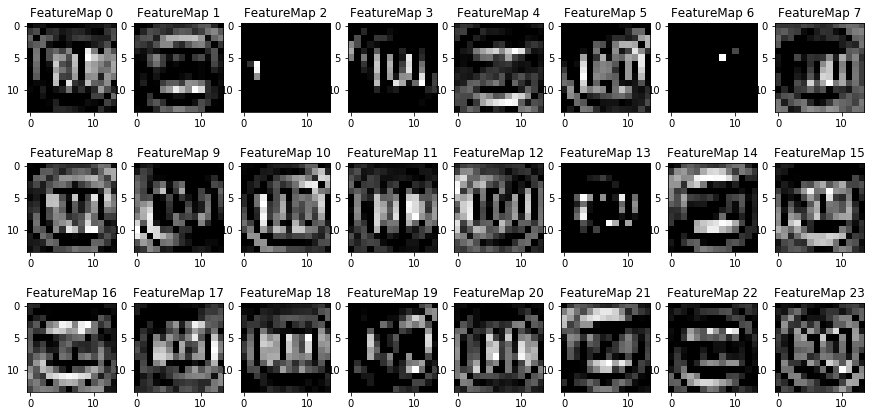

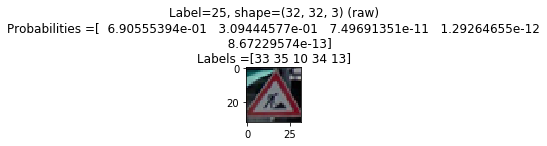

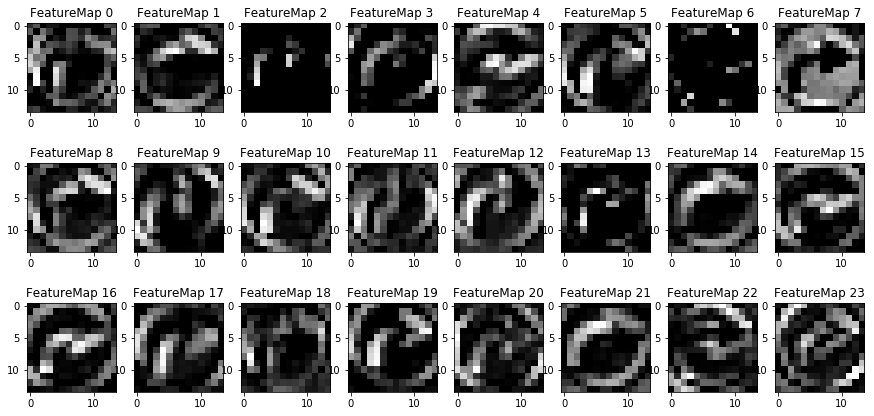

In [39]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x_tensor : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    for index in range(len(X_real)):
        saver = tf.train.Saver()
        saver.restore(sess, './lenet')

        real_label = y_real[index]
        real_image = X_real[index]
        real_image_pre = X_real_pre[index]

        plt.figure(figsize=(1,1))
        plt.imshow(real_image.squeeze(), cmap="gray")
        plt.title("Label={}, shape={} (raw)".format(key,real_image.shape) + "\n" \
                + "Probabilities =" + str(found_probabilities) + "\n" \
                + "Labels =" + str(found_labels))

        plt.show()
        outputFeatureMap(np.expand_dims(real_image_pre,0), activation_layers[0], activation_min=-1, activation_max=-1 ,plt_num=1)
